In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import utils, datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import matplotlib.animation as animation
from IPython.display import HTML
import time

In [0]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
!mkdir runs
%tensorboard --logdir 'runs'
# clear the output after execution

In [3]:
# Tunnel localhost to a webpage using ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('tensorboard --logdir runs --host 0.0.0.0 --port 6006 &')
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-05-17 18:01:09--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.84.72.55, 34.193.189.199, 3.90.94.177, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.84.72.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  17.5MB/s    in 0.7s    

2020-05-17 18:01:10 (17.5 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://5ba5513e.ngrok.io


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
batch_size = 100
transform = transforms.Compose([
                                transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
dataset = datasets.CIFAR10(root='./', transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
nz = 110

Extracting ./cifar-10-python.tar.gz to ./


torch.Size([100, 3, 32, 32])
torch.Size([100])


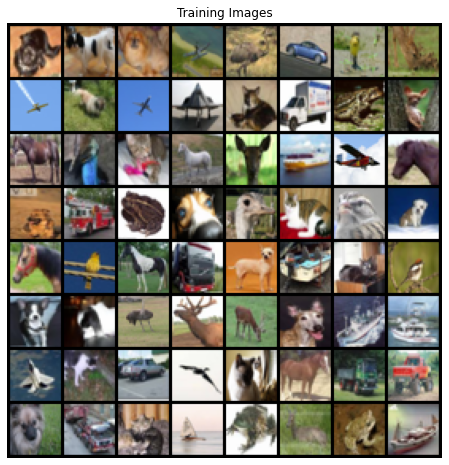

In [6]:
real_batch = next(iter(dataloader))
print(real_batch[0].shape, real_batch[1].shape, sep='\n')
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [0]:
class Generator(nn.Module):
  """
  Generator Network
  Inputs : noise, class label
  Output : (-1, 3, 32, 32) Tensor
  """
  def __init__(self):
    super().__init__()
    in_channels = nz
    self.fc1 = nn.Linear(nz, 384)
    self.conv1 = nn.Sequential(
        nn.ConvTranspose2d(384, 192, 4, 1, 0),
        nn.BatchNorm2d(192),
        nn.ReLU(),
    )
    self.conv2 = nn.Sequential(
        nn.ConvTranspose2d(192, 96, 4, 2, 1),
        nn.BatchNorm2d(96),
        nn.ReLU(),
    )
    self.conv3 = nn.Sequential(
        nn.ConvTranspose2d(96, 48, 4, 2, 1),
        nn.BatchNorm2d(48),
        nn.ReLU(),
    )
    self.conv4 = nn.Sequential(
        nn.ConvTranspose2d(48, 3, 4, 2, 1),
        nn.Tanh(),
    )

  def forward(self, x):
    x = x.view(-1, nz)
    x = self.fc1(x)
    x = x.view(-1, 384, 1, 1)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    return x

In [0]:
class Discriminator(nn.Module):

  def __init__(self):
    super().__init__()
    classes = 10
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 16, 3, 2, 1),
        nn.LeakyReLU(0.2),
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, 3, 1, 1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.5)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(32, 64, 3, 2, 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.5),
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(64, 128, 3, 1, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.5),
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(128, 256, 3, 2, 1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.5),
    )
    self.conv6 = nn.Sequential(
        nn.Conv2d(256, 512, 3, 1, 1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.5),
    )
    self.fc_source = nn.Sequential(
        nn.Linear(4*4*512, 1),
        nn.Sigmoid()
    )
    self.fc_class = nn.Sequential(
        nn.Linear(4*4*512, classes),
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = x.view(-1, 4*4*512)
    src = self.fc_source(x).view(-1,1).squeeze(1)
    cls = self.fc_class(x)
    return src, cls

In [0]:
def weights_init(m):
  """ Weights initialization as proposed in the paper. """
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)
      nn.init.constant_(m.bias.data, 0)
      
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)

In [10]:
gen = Generator().to(device)
gen.apply(weights_init)
summary(gen, (nz,))
nz_tb = torch.randn(batch_size, nz, 1, 1, device=device)
gen_writer = SummaryWriter()
gen_writer.add_graph(gen, nz_tb)
gen_writer.close()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 384]          42,624
   ConvTranspose2d-2            [-1, 192, 4, 4]       1,179,840
       BatchNorm2d-3            [-1, 192, 4, 4]             384
              ReLU-4            [-1, 192, 4, 4]               0
   ConvTranspose2d-5             [-1, 96, 8, 8]         295,008
       BatchNorm2d-6             [-1, 96, 8, 8]             192
              ReLU-7             [-1, 96, 8, 8]               0
   ConvTranspose2d-8           [-1, 48, 16, 16]          73,776
       BatchNorm2d-9           [-1, 48, 16, 16]              96
             ReLU-10           [-1, 48, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]           2,307
             Tanh-12            [-1, 3, 32, 32]               0
Total params: 1,594,227
Trainable params: 1,594,227
Non-trainable params: 0
---------------------------

In [11]:
disc = Discriminator().to(device)
disc.apply(weights_init)
summary(disc, (3, 32, 32))
disc_writer = SummaryWriter()
disc_writer.add_graph(disc, real_batch[0].to(device))
disc_writer.close()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
         LeakyReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
       BatchNorm2d-4           [-1, 32, 16, 16]              64
         LeakyReLU-5           [-1, 32, 16, 16]               0
           Dropout-6           [-1, 32, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
         LeakyReLU-9             [-1, 64, 8, 8]               0
          Dropout-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
      BatchNorm2d-12            [-1, 128, 8, 8]             256
        LeakyReLU-13            [-1, 128, 8, 8]               0
          Dropout-14            [-1, 12

In [0]:
beta1 = 0.5
lr = 0.0002
optimD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999))
optimG = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, 0.999))
criterion_src = nn.BCELoss()
criterion_cls =nn.CrossEntropyLoss()
real_label = 1.0
fake_label = 0.0
test_noise = torch.randn(64, 110, 1, 1, device=device)

In [0]:
def compute_acc(preds, labels):
    correct = 0.0
    preds = torch.max(preds, 1)[1]
    correct = preds.eq(labels.data).sum()
    acc = (correct * 100.0)/ len(labels.data)
    return acc

In [14]:
avg_loss_D = 0.0
avg_loss_G = 0.0
avg_loss_A = 0.0
iters = 0
num_epochs = 300
total_time = 0.0
"""
L_s = E[logP(S = real | X_real)] + E[logP(S=fake | X_fake)]
L_c = E[logP(C = c | X_real)] + E[logP(C = c | X_fake)]
D is trained to maximize L_s + L_c while G is trained to maximize L_c − L_s.
"""
writer = SummaryWriter()
writer.close()

for epoch in range(num_epochs):

  for i, data in enumerate(dataloader, 0):

    f = 0
    if (i % 100 == 0) or (i == len(dataloader)-1):
      f = 1
    
    start_time = time.time()
    #################
    # Discriminator #
    #################

    # Real Images
    disc.zero_grad()
    real_image, real_class = data
    real_image = real_image.to(device)
    real_class = real_class.to(device)
    src_label = torch.full((batch_size,), real_label, device=device)
    cls_label = real_class.view(batch_size,)

    src, cls = disc(real_image)
    errD_src_real = criterion_src(src, src_label)
    errD_cls_real = criterion_cls(cls, cls_label)
    if f==1:
      disc_writer.add_scalars('Discriminator/Real/src-cls', {'Source Error':errD_src_real.item(), 
                                                             'Class Error':errD_cls_real.item()}, iters)
    errD_real = errD_src_real + errD_cls_real
    errD_real.backward()
    D_x = src.mean().item()
    accuracy = compute_acc(cls, cls_label)
    if f==1:
      disc_writer.add_scalar('Discriminator/Accuracy', accuracy, iters)
    
    # Fake Images
    noise = torch.randn(batch_size, nz, 1, 1, device=device)
    cls_label = torch.randint(0, 2, (batch_size,), device=device)
    src_label.fill_(fake_label)

    fake = gen(noise)
    src, cls = disc(fake.detach())
    errD_src_fake = criterion_src(src, src_label)
    errD_cls_fake = criterion_cls(cls, cls_label)
    if f==1:
      disc_writer.add_scalars('Discriminator/Fake/src-cls', {'Source Error':errD_src_fake.item(), 
                                                             'Class Error':errD_cls_fake.item()}, iters)
    errD_fake = errD_src_fake + errD_cls_fake
    errD_fake.backward()
    D_G_z1 = src.mean().item()
    errD = errD_real + errD_fake
    if f==1:
      disc_writer.add_scalars('Discriminator/Total Error', {'Real':errD_real.item(), 
                                                            'Fake':errD_fake.item(), 
                                                            'Total':errD.item()}, iters)
      disc_writer.close()

    optimD.step()

    #############
    # Generator #
    #############

    gen.zero_grad()
    src_label.fill_(real_label)

    src, cls = disc(fake)
    errG_src = criterion_src(src, src_label)
    errG_cls = criterion_cls(cls, cls_label)
    if f==1:
      gen_writer.add_scalars('Generator/src-cls', {'Source Error':errG_src.item(), 
                                                   'Class Error':errG_cls.item()}, iters)
    errG = errG_src + errG_cls
    if f==1:
      gen_writer.add_scalar('Generator/Total Error', errG.item(), iters)
      gen_writer.close()
    errG.backward()
    D_G_z2 = src.mean().item()
    if f==1:
      writer.add_scalars('Values', {'D(x)':D_x,
                                    'D(G(z1))':D_G_z1,
                                    'D(G(z2))':D_G_z2}, iters)
      writer.add_scalars('Loss', {'Discriminator':errD.item(),
                                  'Generator':errG.item()}, iters)

    optimG.step()

    curr_iter = epoch * len(dataloader) + i
    all_loss_G = avg_loss_G * curr_iter
    all_loss_D = avg_loss_D * curr_iter
    all_loss_A = avg_loss_A * curr_iter
    all_loss_G += errG.item()
    all_loss_D += errD.item()
    all_loss_A += accuracy
    avg_loss_G = all_loss_G / (curr_iter + 1)
    avg_loss_D = all_loss_D / (curr_iter + 1)
    avg_loss_A = all_loss_A / (curr_iter + 1)
    if f==1:
      writer.add_scalars('Average Loss', {'Generator Loss':avg_loss_G,
                                          'Discriminator Loss':avg_loss_D,
                                          'Accuracy':avg_loss_A}, iters)
    
    el_time = time.time() - start_time
    if f==1:
      writer.add_scalar('Time per batch', el_time, iters)
      writer.close()
    total_time += el_time

    if (i == len(dataloader)-1):
      fake = gen(test_noise)
      grid = utils.make_grid(fake, padding=2, normalize=True)
      writer.add_image('Fake Images', grid, epoch)
      writer.close()
    iters += 1
  
  print(f'Epoch {epoch} / {num_epochs} complete\tTime Elapsed : {total_time} s')

Epoch 0 / 300 complete	Time Elapsed : 18.460124969482422 s
Epoch 1 / 300 complete	Time Elapsed : 36.795122146606445 s
Epoch 2 / 300 complete	Time Elapsed : 55.168290853500366 s
Epoch 3 / 300 complete	Time Elapsed : 73.55295395851135 s
Epoch 4 / 300 complete	Time Elapsed : 91.95967197418213 s
Epoch 5 / 300 complete	Time Elapsed : 110.2405457496643 s
Epoch 6 / 300 complete	Time Elapsed : 128.63133096694946 s
Epoch 7 / 300 complete	Time Elapsed : 147.0946798324585 s
Epoch 8 / 300 complete	Time Elapsed : 165.57419681549072 s
Epoch 9 / 300 complete	Time Elapsed : 183.94406652450562 s
Epoch 10 / 300 complete	Time Elapsed : 202.3315486907959 s
Epoch 11 / 300 complete	Time Elapsed : 220.83517479896545 s
Epoch 12 / 300 complete	Time Elapsed : 239.40462517738342 s
Epoch 13 / 300 complete	Time Elapsed : 257.8260865211487 s
Epoch 14 / 300 complete	Time Elapsed : 276.1374158859253 s
Epoch 15 / 300 complete	Time Elapsed : 294.6000089645386 s
Epoch 16 / 300 complete	Time Elapsed : 312.99153184890747 

In [0]:
torch.save(gen.state_dict(), './gen.pt')
torch.save(disc.state_dict(), './disc.pt')

In [0]:
!zip -r /content/runs.zip /content/runs/